# Clean up the big .csv file for easier use with my other codes

### Run the compileOCdata.ipynb first

I will use RA, Dec, coordinates from Simbad when possible.

The final file should have columns with IDs from all sources (as available), RA, Dec, distance, Age, Metallicity, Mass, Rgc, Rhm (all as available)

In [1]:
import pandas as pd
import numpy as np
import sys
import time
import re

from astropy.coordinates import SkyCoord
from astropy import units 

from astroquery.simbad import Simbad
Simbad.TIMEOUT = 300 # sets the timeout to 60s

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 100)

%matplotlib inline

In [2]:
matchCoord = False

## Get the coordinates

In [3]:
#it turns out that Simbad coordinates are not great.  So I actually don't need to do this...
#BUT I want a way to know which stars have a good Simbad match and which don't ... so I will do this anyway
def getSimbadRADec(match_ID):

    RA = np.full(len(match_ID), np.nan, dtype='object')
    Dec = np.full(len(match_ID), np.nan, dtype='object')


#     result_table = Simbad.query_objects(match_ID) #stupidly, this does not return blank rows for missing data!
# So I'm trying to go one line at a time, but of course Simbad doesn't like that... it rejects my connection when
# I have too many requests (and what is too many?  and how long should I wait?)
    for i, ID in enumerate(match_ID):
        result_table = Simbad.query_object(ID)
        if (result_table):
            #print(result_table.columns)
            if (len(result_table) > 0):
                row = result_table[0]
                RA[i] = row['RA']
                Dec[i] = row['DEC']
        print(f'{i} {float(i)/len(match_ID):5.3f}, {ID} {RA[i]} {Dec[i]} -- ', end='')
        if (i>0 and i % 50 == 0):
            time.sleep(30)
            print('\n\n')
        time.sleep(0.1)

        
    return RA, Dec

In [4]:
def getCoord(row):

    if (pd.notna(row['_RAJ2000_cantat-gaudin']) and pd.notna(row['_DEJ2000_cantat-gaudin'])):
        return SkyCoord(ra=row['_RAJ2000_cantat-gaudin']+' hours', dec=row['_DEJ2000_cantat-gaudin']+' degree', frame='icrs')
    
    elif (pd.notna(row['ra_mwsc']) and pd.notna(row['dec_mwsc'])):
        return SkyCoord(ra=row['ra_mwsc']+' hours', dec=row['dec_mwsc']+' degree', frame='icrs')
        
    elif (pd.notna(row['RA[hr]_kharchenko']) and pd.notna(row['Dec[deg]_kharchenko'])):
        return SkyCoord(ra=row['RA[hr]_kharchenko']*units.hourangle, dec=row['Dec[deg]_kharchenko']*units.degree, frame='icrs')

    elif (pd.notna(row['GLON[deg]_piskunov']) and pd.notna(row['GLAT[deg]_piskunov'])):
        return SkyCoord(l=row['GLON[deg]_piskunov']*units.degree, b=row['GLAT[deg]_piskunov']*units.degree, frame='galactic').icrs

    elif (pd.notna(row['ra_lynga']) and pd.notna(row['dec_lynga'])):
        return SkyCoord(ra=row['ra_lynga']*units.degree, dec=row['dec_lynga']*units.degree, frame='icrs')
    
    elif (pd.notna(row['_RA[deg]_vandenbergh']) and pd.notna(row['_Dec[deg]_vandenbergh'])):
        return SkyCoord(ra=row['_Dec[deg]_vandenbergh']*units.degree, dec=row['_Dec[deg]_vandenbergh']*units.degree, frame='icrs')

    elif (pd.notna(row['RA_2000_webda']) and pd.notna(row['Dec_2000_webda'])):
        return SkyCoord(ra=row['RA_2000_webda']+' hours', dec=row['Dec_2000_webda']+' degree', frame='icrs')
            
    elif (pd.notna(row['GLON[deg]_cantat-gaudin']) and pd.notna(row['GLAT[deg]_cantat-gaudin'])):
        return SkyCoord(l=row['GLON[deg]_cantat-gaudin']*units.degree, b=row['GLAT[deg]_cantat-gaudin']*units.degree, frame='galactic').icrs

    elif (pd.notna(row['l_webda']) and pd.notna(row['b_webda'])):
        return SkyCoord(l=row['l_webda']*units.degree, b=row['b_webda']*units.degree, frame='galactic').icrs
    
    else:
        print('NO RA, Dec : ', row['Simbad_ID'])
        return False

In [5]:
OC_df = pd.read_csv('OCcompiled.csv')
OC_df

,Simbad_ID,Name_mwsc,broad_type_mwsc,cluster_status_mwsc,ra_mwsc,dec_mwsc,lii_mwsc,bii_mwsc,core_radius_mwsc,central_radius_mwsc,cluster_radius_mwsc,pm_ra_mwsc,pm_dec_mwsc,pm_tot_error_mwsc,rad_vel_mwsc,rad_vel_error_mwsc,num_rad_vel_stars_mwsc,num_core_stars_mwsc,num_central_stars_mwsc,num_cluster_stars_mwsc,distance_mwsc,e_bv_mwsc,distance_modulus_mwsc,e_jk_mwsc,e_jh_mwsc,delta_h_mwsc,log_age_mwsc,log_age_error_mwsc,num_log_age_stars_mwsc,king_core_radius_mwsc,king_core_radius_error_mwsc,king_tidal_radius_mwsc,king_tidal_radius_error_mwsc,king_norm_factor_mwsc,king_norm_factor_error_mwsc,reference_code_mwsc,cluster_type_mwsc,metallicity_mwsc,metallicity_error_mwsc,num_metallicity_stars_mwsc,comments_mwsc,class_mwsc,Name_webda,RA_2000_webda,Dec_2000_webda,l_webda,b_webda,Dist_webda,Mod_webda,EB-V_webda,Age_webda,ST_webda,Z_webda,Diam_webda,Fe/H_webda,MRV_webda,pm RA_webda,pm Dec_webda,Measures_webda,Stars_webda,COCD_piskunov,Name_piskunov,GLON[deg]_piskunov,GLAT[deg]_piskunov,DistMod_piskunov,E(B-V)_piskunov,Dist[pc]_piskunov,logt[yr]_piskunov,rt[pc]_piskunov,e_rt[pc]_piskunov,logM[MSun]_piskunov,e_logM[MSun]_piskunov,rtA[pc]_piskunov,e_rtA[pc]_piskunov,logMA[MSun]_piskunov,e_logMA[MSun]_piskunov,MWSC_kharchenko,Name_kharchenko,Type_kharchenko,n_Type_kharchenko,RA[hr]_kharchenko,Dec[deg]_kharchenko,GLON[deg]_kharchenko,GLAT[deg]_kharchenko,r0[deg]_kharchenko,r1[deg]_kharchenko,r2[deg]_kharchenko,pmRA[mas/yr]_kharchenko,pmDec[mas/yr]_kharchenko,e_pm[mas/yr]_kharchenko,RV[km/s]_kharchenko,e_RV[km/s]_kharchenko,n_RV[km/s]_kharchenko,N1sr0_kharchenko,N1sr1_kharchenko,N1sr2_kharchenko,d[pc]_kharchenko,E(B-V)_kharchenko,appDistMod[mag]_kharchenko,E(J-Ks)_kharchenko,E(J-H)_kharchenko,dH_kharchenko,logt[yr]_kharchenko,e_logt[yr]_kharchenko,Nt_kharchenko,rc[pc]_kharchenko,e_rc[pc]_kharchenko,rt[pc]_kharchenko,e_rt[pc]_kharchenko,k[pc-2]_kharchenko,e_k[pc-2]_kharchenko,Src_kharchenko,SType_kharchenko,[Fe/H][Sun]_kharchenko,e_[Fe/H][Sun]_kharchenko,n_[Fe/H]_kharchenko,Name_salaris,dV_salaris,err_dV_salaris,[Fe/H]_salaris,err_[Fe/H]_salaris,t[Gyr]_salaris,err_t_salaris,Rgc[kpc]_salaris,z[pc]_salaris,flag_salaris,tJP94[Gyr]_salaris,Seq_vandenbergh,Name_vandenbergh,l[deg]_vandenbergh,Diam[pc]_vandenbergh,R[pc]_vandenbergh,Z[pc]_vandenbergh,E(B-V)_vandenbergh,logT[yr]_vandenbergh,SimbadName_vandenbergh,_RA[deg]_vandenbergh,_Dec[deg]_vandenbergh,_RAJ2000_cantat-gaudin,_DEJ2000_cantat-gaudin,Name_cantat-gaudin,RAJ2000[deg]_cantat-gaudin,DEJ2000[deg]_cantat-gaudin,GLON[deg]_cantat-gaudin,GLAT[deg]_cantat-gaudin,r50[deg]_cantat-gaudin,Nstars_cantat-gaudin,pmRA[mas/yr]_cantat-gaudin,pmDE[mas/yr]_cantat-gaudin,plx[mas]_cantat-gaudin,dmode[pc]_cantat-gaudin,Rgc[pc]_cantat-gaudin,SimbadName_cantat-gaudin,Name_lynga,ra_lynga,dec_lynga,distance_lynga,log_age_lynga,angular_diameter_lynga,alt_name_lynga,lii_lynga,bii_lynga,iau_num_lynga,seq_code_lynga,seq_num_lynga,prec_ra_lynga,prec_dec_lynga,lund_record_num_lynga,ocl_num_lynga,ref_angular_diameter_lynga,ref_distance_lynga,ref_log_age_lynga,metallicity_lynga,ref_metallicity_lynga,e_bv_lynga,ref_e_bv_lynga,type_flag_lynga,ref_type_flag_lynga,tr_concent_class_lynga,tr_range_class_lynga,tr_richness_class_lynga,tr_nebulosity_lynga,sb_bs_mag_lynga,sb_spect_code_lynga,sb_total_mag_lynga,sk_total_mag_lynga,sk_bv_color_lynga,sk_num_stars_lynga,ja_star_num_lynga,ja_class_lynga,ja_max_class_lynga,ja_richness_lynga,ja_e_bv_lynga,ref_ja_e_bv_lynga,ja_bv_turnoff_lynga,ref_ja_bv_turnoff_lynga,ly_tr_concent_class_lynga,ly_tr_range_class_lynga,ly_tr_richness_class_lynga,ly_tr_nebulosity_lynga,ly_member_stars_lynga,ly_angular_diameter_lynga,ly_refs_flag_lynga,radvel_weight_lynga,radvel_lynga,radvel_weight_class_lynga,ref_radvel1_lynga,ref_radvel2_lynga,ref_radvel3_lynga,ref_radvel4_lynga,ref_radvel5_lynga,basel_spect_code_lynga,basel_color_type_lynga,neg_ra_tracer_lynga,neg_lii_tracer_lynga,neg_seq_num_tracer_lynga,pos_ra_tracer_lynga,pos_lii_tracer_lynga,pos_seq_num_tracer_lynga,jdl_distance_lynga,jdl_distance_weight

In [6]:
RA = np.full(len(OC_df), np.nan, dtype='object')
Dec = np.full(len(OC_df), np.nan, dtype='object')
for index, row in OC_df.iterrows():
    #RA and Dec
    c = getCoord(row)
    if (c):
        RA[index] = c.ra.to_string(sep=' ', pad=True, unit=units.hour, precision=3)
        Dec[index] = c.dec.to_string(sep=' ', pad=True, unit=units.degree, precision=3)
    else:
        print('WARNING: no coordinates!', row['Simbad_ID'])

In [7]:
#this takes a while...
if (matchCoord):
    RA_Simbad, Dec_Simbad = getSimbadRADec(OC_df['Simbad_ID'].values)
    

In [8]:
if (matchCoord):
    simbad_ID = OC_df['Simbad_ID'].values.copy()
    for index, row in  OC_df.iterrows():
        if (pd.isna(RA_Simbad[index])):
            simbad_ID[index] = np.nan
    print(simbad_ID)
    #write this to an intermediate file so that I don't need to match to Simbad again!
    cleanOC_df = pd.DataFrame()
    cleanOC_df['ID'] = OC_df['Simbad_ID'] #note: this contains some IDs that are not in Simbad
    cleanOC_df['RA'] = RA
    cleanOC_df['Dec'] = Dec
    cleanOC_df['ID_Simbad'] = simbad_ID
    cleanOC_df.to_csv('OCcompiled_clean_v1.csv', index=False)

In [26]:
# foo = pd.DataFrame()
# foo['ID'] = cleanOC_df['ID']
# foo['RA'] = cleanOC_df['RA']
# foo['Dec'] = cleanOC_df['Dec']
# foo['ID_Simbad'] = cleanOC_df['ID_Simbad']
# foo.to_csv('OCcompiled_clean_v1.csv', index=False)

*Below, we can work with this cleanOC_df so that I don't have to go through the Simbad matching again!*

In [27]:
cleanOC_df = pd.read_csv('OCcompiled_clean_v1.csv')
cleanOC_df

,ID,RA,Dec,ID_Simbad
0,[KPS2012]_MWSC_4688,23 51 54.000,-86 43 12.000,[KPS2012]_MWSC_4688
1,[KPS2012]_MWSC_5684,12 53 43.000,-86 38 54.000,NaN
2,[KPS2012]_MWSC_5692,17 47 20.000,-86 36 36.000,NaN
3,[KPS2012]_MWSC_4005,00 11 28.000,-85 28 48.000,[KPS2012]_MWSC_4005
4,[KPS2012]_MWSC_4176,14 27 18.000,-85 25 12.000,[KPS2012]_MWSC_4176
5,ESO_8-6,14 56 55.000,-83 26 42.000,ESO_8-6
6,[KPS2012]_MWSC_4219,15 42 14.000,-83 11 42.000,[KPS2012]_MWSC_4219
7,[KPS2012]_MWSC_5575,01 59 42.000,-83 03 00.000,NaN
8,[KPS2012]_MWSC_4682,23 43 23.000,-82 57 36.000,[KPS2012]_MWSC_4682
9,[KPS2012]_MWSC_5685,13 05 24.000,-82 02 36.000,NaN


### Add all the IDs

In [28]:
#add a column with the actual Simbad ID in the cleaned table, with NaN when there isn't a match
cleanOC_df['ID_MWSC'] = OC_df['Name_mwsc']
cleanOC_df['ID_WEBDA'] = OC_df['Name_webda']
cleanOC_df['ID_Piskunov'] = OC_df['Name_piskunov']
cleanOC_df['ID_Kharchenko'] = OC_df['Name_kharchenko']
cleanOC_df['ID_Salaris'] = OC_df['Name_salaris']
cleanOC_df['ID_vandenBergh'] = OC_df['Name_vandenbergh']
cleanOC_df['ID_Cantat-Gaudin'] = OC_df['Name_cantat-gaudin']
cleanOC_df['ID_Lynga'] = OC_df['Name_lynga']

### Distance

In [29]:
def getDistance(row):
    #take a mean if there are more than 1
    distances = []
    if (pd.notna(row['distance_mwsc'])):
        distances.append(row['distance_mwsc'])
        
    if (pd.notna(row['dmode[pc]_cantat-gaudin'])):
        distances.append(row['dmode[pc]_cantat-gaudin'])    

    if (pd.notna(row['Dist_webda'])):
        distances.append(row['Dist_webda'])    
        
    if (pd.notna(row['distance_lynga'])):
        distances.append(row['distance_lynga'])
        
    if (pd.notna(row['d[pc]_kharchenko'])):
        distances.append(row['d[pc]_kharchenko'])    
        
    if (pd.notna(row['Dist[pc]_piskunov'])):
        distances.append(row['Dist[pc]_piskunov'])
        
    if (pd.notna(row['R[pc]_vandenbergh'])):
        distances.append(row['R[pc]_vandenbergh'])
        

    if (len(distances) > 0):
        distances = np.array(distances)
        return (np.mean(distances), np.std(distances)/(len(distances))**0.5, len(distances))
    else:
        print('NO DISTANCE', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [30]:
dist = []
err_dist = []
n_dist = []
for index, row in OC_df.iterrows():
    m,em,nm  = getDistance(row)
    dist.append(m)    
    err_dist.append(em)
    n_dist.append(nm)
cleanOC_df['dist[pc]'] = dist
cleanOC_df['err_dist[pc]'] = err_dist
cleanOC_df['N_dist[pc]'] = n_dist

NO DISTANCE NGC_5120
NO DISTANCE NGC_5385
NO DISTANCE NGC_6863
NO DISTANCE C_0001+557
NO DISTANCE C_0219+636
NO DISTANCE C_0257+602
NO DISTANCE C_0403+273
NO DISTANCE C_0516+732
NO DISTANCE C_0520+332
NO DISTANCE C_0736-104
NO DISTANCE C_0843-315
NO DISTANCE C_0847-466
NO DISTANCE ESO_167-12
NO DISTANCE C_1004-601
NO DISTANCE Dol-Dzim_1
NO DISTANCE C_1623-261
NO DISTANCE C_1652-407
NO DISTANCE Dol-Dzim_7
NO DISTANCE C_1727-370
NO DISTANCE Cl_Collinder_345
NO DISTANCE C_1832+051
NO DISTANCE C_1935+002
NO DISTANCE Cl_Berkeley_48
NO DISTANCE C_2015+365
NO DISTANCE C_2017+375
NO DISTANCE C_2019+412
NO DISTANCE C_2024+399
NO DISTANCE C_2058+679
NO DISTANCE NGC_7023
NO DISTANCE C_0736-359
NO DISTANCE C_0845-527
NO DISTANCE Av-hunter_1
NO DISTANCE Latysev_1
NO DISTANCE Cl_Basel_11
NO DISTANCE Loden_282
NO DISTANCE Loden_336


### Age

In [31]:
def getLogAge(row):
    #take a mean if there are more than 1
    ages = []
    if (pd.notna(row['log_age_mwsc'])):
        ages.append(10.**row['log_age_mwsc']/10.**6)
        
    if (pd.notna(row['Age_webda'])):
        ages.append(row['Age_webda'])
        
    if (pd.notna(row['log_age_lynga'])):
        ages.append(10.**row['log_age_lynga']/10.**6)
        
    if (pd.notna(row['logt[yr]_kharchenko'])):
        ages.append(10.**row['logt[yr]_kharchenko']/10.**6)
        
    if (pd.notna(row['logt[yr]_piskunov'])):
        ages.append(10.**row['logt[yr]_piskunov']/10.**6)
        
    if (pd.notna(row['logT[yr]_vandenbergh'])):
        if (row['logT[yr]_vandenbergh'].isnumeric()):
            ages.append(10.**row['logT[yr]_vandenbergh']/10.**6)
        
    if (pd.notna(row['t[Gyr]_salaris'])):
        ages.append(row['t[Gyr]_salaris']*10.**3)
        
    if (len(ages) > 0):
        ages = np.array(ages)
        return (np.mean(ages), np.std(ages)/(len(ages))**0.5, len(ages))
    else:
        print('NO AGE', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [32]:
age = []
err_age = []
n_age = []
for index, row in OC_df.iterrows():
    m,em,nm  = getLogAge(row)
    age.append(m)    
    err_age.append(em)
    n_age.append(nm)
cleanOC_df['age[Myr])'] = age
cleanOC_df['err_age[Myr]'] = err_age
cleanOC_df['N_age[Myr]'] = n_age

NO AGE C_1232+365
NO AGE NGC_5120
NO AGE NGC_5385
NO AGE NGC_6863
NO AGE NGC_6996
NO AGE NGC_1758
NO AGE C_0802-461
NO AGE C_1042-593
NO AGE NAME_HIP_67330_Cluster
NO AGE Havlen_Moffat_1
NO AGE NAME_Alessi_24
NO AGE Cl_Alessi_31
NO AGE Name_Cl_Alessi_Teutsch_11
NO AGE Name_Cl_Alessi_Teutsch_3
NO AGE Name_Cl_Alessi_Teutsch_8
NO AGE Cl_Antalova_2
NO AGE Aveni_Hunter_1
NO AGE NAME_Cl_Barkhatova_1
NO AGE NAME_Ferrero_11
NO AGE Gulliver_1
NO AGE Gulliver_10
NO AGE Gulliver_11
NO AGE Gulliver_12
NO AGE Gulliver_13
NO AGE Gulliver_14
NO AGE Gulliver_15
NO AGE Gulliver_16
NO AGE Gulliver_17
NO AGE Gulliver_18
NO AGE Gulliver_19
NO AGE Gulliver_2
NO AGE Gulliver_20
NO AGE Gulliver_21
NO AGE Gulliver_22
NO AGE Gulliver_23
NO AGE Gulliver_24
NO AGE Gulliver_25
NO AGE Gulliver_26
NO AGE Gulliver_27
NO AGE Gulliver_28
NO AGE Gulliver_29
NO AGE Gulliver_3
NO AGE Gulliver_30
NO AGE Gulliver_31
NO AGE Gulliver_32
NO AGE Gulliver_33
NO AGE Gulliver_34
NO AGE Gulliver_35
NO AGE Gulliver_36
NO AGE Gulliv

### Metallicity

In [33]:
def getFeH(row):
    #take a mean if there are more than 1
    FeHs = []
    if (pd.notna(row['metallicity_mwsc'])):
        if (row['metallicity_mwsc'].isnumeric()):
            FeHs.append(row['metallicity_mwsc'])
            
    if (pd.notna(row['Fe/H_webda'])):
        FeHs.append(row['Fe/H_webda'])
        
    if (pd.notna(row['[Fe/H][Sun]_kharchenko'])):
        FeHs.append(row['[Fe/H][Sun]_kharchenko'])
        
    if (pd.notna(row['[Fe/H]_salaris'])):
        FeHs.append(row['[Fe/H]_salaris'])

    if (pd.notna(row['metallicity_lynga'])):
        FeHs.append(row['metallicity_lynga'])
        
    if (len(FeHs) > 0):
        FeHs = np.array(FeHs)
        return (np.mean(FeHs), np.std(FeHs)/(len(FeHs))**0.5, len(FeHs))
    else:
        print('NO FeH', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [34]:
FeH = []
err_FeH = []
n_FeH = []
for index, row in OC_df.iterrows():
    m,em,nm  = getFeH(row)
    FeH.append(m)    
    err_FeH.append(em)
    n_FeH.append(nm)
cleanOC_df['FeH'] = FeH
cleanOC_df['err_FeH'] = err_FeH
cleanOC_df['N_FeH'] = n_FeH

NO FeH [KPS2012]_MWSC_4688
NO FeH [KPS2012]_MWSC_5684
NO FeH [KPS2012]_MWSC_5692
NO FeH [KPS2012]_MWSC_4005
NO FeH [KPS2012]_MWSC_4176
NO FeH ESO_8-6
NO FeH [KPS2012]_MWSC_4219
NO FeH [KPS2012]_MWSC_5575
NO FeH [KPS2012]_MWSC_4682
NO FeH [KPS2012]_MWSC_5685
NO FeH [KPS2012]_MWSC_5681
NO FeH [KPS2012]_MWSC_2014
NO FeH [KPS2012]_MWSC_2064
NO FeH [KPS2012]_MWSC_2049
NO FeH [KPS2012]_MWSC_5688
NO FeH ESO_26-2
NO FeH [KPS2012]_MWSC_4137
NO FeH Cl_Melotte_227
NO FeH [KPS2012]_MWSC_5679
NO FeH [KPS2012]_MWSC_5572
NO FeH [KPS2012]_MWSC_5749
NO FeH ESO_21-6
NO FeH [KPS2012]_MWSC_5672
NO FeH [KPS2012]_MWSC_4114
NO FeH [KPS2012]_MWSC_5680
NO FeH [KPS2012]_MWSC_1955
NO FeH [KPS2012]_MWSC_5698
NO FeH [KPS2012]_MWSC_2358
NO FeH [KPS2012]_MWSC_4140
NO FeH [KPS2012]_MWSC_2089
NO FeH [KPS2012]_MWSC_1638
NO FeH Chamaleon_I
NO FeH [KPS2012]_MWSC_4668
NO FeH [KPS2012]_MWSC_2083
NO FeH NGC_1520
NO FeH [KPS2012]_MWSC_1673
NO FeH [KPS2012]_MWSC_1940
NO FeH [KPS2012]_MWSC_5676
NO FeH ESO_43-13
NO FeH [FSR2007

NO FeH [KPS2012]_MWSC_1524
NO FeH Cl_Hogg_22
NO FeH [DBS2003]_171
NO FeH ESO_261-3
NO FeH ESO_260-7
NO FeH C_0953-467
NO FeH [KPS2012]_MWSC_1740
NO FeH C_0847-465
NO FeH NGC_2932
NO FeH ESO_258-1
NO FeH Teutsch_103
NO FeH [KPS2012]_MWSC_2043
NO FeH [KPS2012]_MWSC_4498
NO FeH [KPS2012]_MWSC_1609
NO FeH Cl_Lynga_11
NO FeH SAI_94
NO FeH [KPS2012]_MWSC_5705
NO FeH C_0839-461
NO FeH NGC_2645
NO FeH Cl_Ruprecht_121
NO FeH C_0838-459
NO FeH ESO_260-17
NO FeH [KPS2012]_MWSC_1517
NO FeH ESO_275-1
NO FeH C_0843-458
NO FeH [KPS2012]_MWSC_1969
NO FeH ESO_245-9
NO FeH [DBS2003]_108
NO FeH Cl_VDBH_197
NO FeH [KPS2012]_MWSC_1656
NO FeH [KPS2012]_MWSC_1972
NO FeH NGC_6178
NO FeH [KPS2012]_MWSC_2268
NO FeH [KPR2005]_85
NO FeH [KPS2012]_MWSC_1555
NO FeH Cl_Ruprecht_156
NO FeH [DBS2003]_174
NO FeH ESO_265-1
NO FeH [DBS2003]_106
NO FeH [KPS2012]_MWSC_2869
NO FeH ESO_252-14
NO FeH Cl_Lynga_14
NO FeH NAME_Moitinho_1
NO FeH NGC_3446
NO FeH ESO_261-5
NO FeH NGC_2659
NO FeH [KPS2012]_MWSC_4178
NO FeH NGC_6249


NO FeH [KPS2012]_MWSC_5731
NO FeH [FSR2007]_0010
NO FeH C_1829-160
NO FeH Ass_Sgr_OB_6
NO FeH [KPS2012]_MWSC_2489
NO FeH [KPS2012]_MWSC_1109
NO FeH [KPS2012]_MWSC_5312
NO FeH [KPS2012]_MWSC_1269
NO FeH [KPS2012]_MWSC_1163
NO FeH [KPS2012]_MWSC_2942
NO FeH [KPS2012]_MWSC_2609
NO FeH NGC_2414
NO FeH [KPS2012]_MWSC_1252
NO FeH C_0726-153
NO FeH [KPS2012]_MWSC_1122
NO FeH C_0726-152
NO FeH [DBS2003]_1
NO FeH [KPS2012]_MWSC_4572
NO FeH [FSR2007]_0070
NO FeH [KPS2012]_MWSC_5319
NO FeH Cl_Waterloo_7
NO FeH Cl_Alessi_17
NO FeH [KPS2012]_MWSC_4330
NO FeH [KPS2012]_MWSC_2931
NO FeH [KPS2012]_MWSC_0920
NO FeH [KPR2005]_94
NO FeH NGC_6605
NO FeH [KPS2012]_MWSC_1599
NO FeH [KPS2012]_MWSC_1349
NO FeH [KPS2012]_MWSC_2685
NO FeH Cl_Dolidze_28
NO FeH Cl_Kharchenko_2
NO FeH Kronberger_2
NO FeH Ass_Sct_OB_3
NO FeH C_0634-141
NO FeH [KPS2012]_MWSC_1115
NO FeH [KPS2012]_MWSC_5060
NO FeH [KPS2012]_MWSC_1354
NO FeH NAME_Basel_11A
NO FeH NGC_2401
NO FeH [KPS2012]_MWSC_5726
NO FeH [KPS2012]_MWSC_3055
NO FeH [K

NO FeH [KPS2012]_MWSC_0851
NO FeH [FSR2007]_0869
NO FeH [KPR2005]_25
NO FeH [KPS2012]_MWSC_3177
NO FeH [KGZ2008]_62
NO FeH [KPS2012]_MWSC_0662
NO FeH NGC_6800
NO FeH [FSR2007]_0852
NO FeH C_1933+251
NO FeH [FSR2007]_0162
NO FeH Cl_Czernik_41
NO FeH [KPS2012]_MWSC_3219
NO FeH [KPS2012]_MWSC_3286
NO FeH [KPS2012]_MWSC_0576
NO FeH [SSW94]_e
NO FeH [FSR2007]_0858
NO FeH NGC_6904
NO FeH NGC_1996
NO FeH [FSR2007]_0849
NO FeH [KPS2012]_MWSC_5779
NO FeH Dol-Dzim_4
NO FeH [FSR2007]_0773
NO FeH [KPS2012]_MWSC_3182
NO FeH [KPS2012]_MWSC_0357
NO FeH Kronberger_31
NO FeH [KGZ2008]_53
NO FeH NGC_2248
NO FeH [KPS2012]_MWSC_0674
NO FeH Dol-Dzim_3
NO FeH [KPS2012]_MWSC_3401
NO FeH [KPS2012]_MWSC_0345
NO FeH [KPS2012]_MWSC_3399
NO FeH [KPS2012]_MWSC_3210
NO FeH Teutsch_51
NO FeH [BDS2003]_15
NO FeH [KPS2012]_MWSC_3166
NO FeH S_242,Sh2_242
NO FeH [KPS2012]_MWSC_5901
NO FeH [KPS2012]_MWSC_3244
NO FeH [KPS2012]_MWSC_0845
NO FeH C_0147+270
NO FeH [KPS2012]_MWSC_0965
NO FeH [BDS2003]_16
NO FeH [KPS2012]_MWSC

NO FeH C_0037+605
NO FeH NAME_PWM_3
NO FeH [KPS2012]_MWSC_3756
NO FeH Cl_Berkeley_58
NO FeH Cl_Berkeley_6
NO FeH NAME_Alessi-Teutsch_5
NO FeH [KPS2012]_MWSC_0178
NO FeH NGC_189
NO FeH C_0007+609
NO FeH NGC_7790
NO FeH [BDS2003]_44
NO FeH NGC_663
NO FeH [BDS2003]_48
NO FeH C_0132+610
NO FeH [KPS2012]_MWSC_3710
NO FeH [KPS2012]_MWSC_0112
NO FeH NGC_103
NO FeH Cl_Czernik_5
NO FeH C_2323+610
NO FeH NGC_7788
NO FeH [BDS2003]_30
NO FeH IC_1805
NO FeH Ass_Cas_OB_1
NO FeH Cl_Czernik_4
NO FeH [KPS2012]_MWSC_0025
NO FeH C_0005+611
NO FeH NGC_7538
NO FeH NGC_136
NO FeH [KPR2005]_4
NO FeH NGC_1027
NO FeH Frolov_1
NO FeH [KPS2012]_MWSC_3615
NO FeH [FSR2007]_0584
NO FeH Teutsch_76
NO FeH M_52
NO FeH C_2351+614
NO FeH NAME_Cl_Mayer_1
NO FeH NGC_225
NO FeH C_0225+615
NO FeH NGC_654
NO FeH NAME_Majaess_225
NO FeH Cl_Czernik_44
NO FeH Cl_King_12
NO FeH Cl_Czernik_17
NO FeH Cl_Stock_24
NO FeH TYC_4051-2533-1
NO FeH NAME_W_3_OH
NO FeH Teutsch_55
NO FeH [KPS2012]_MWSC_3670
NO FeH [KPS2012]_MWSC_0092
NO FeH

### Masses

In [35]:
def getMass(row, mm = 0.5):
    #take a mean if there are more than 1
    masses = []
    if (pd.notna(row['num_cluster_stars_mwsc'])):
        masses.append(row['num_cluster_stars_mwsc']*mm)
        
    if (pd.notna(row['Nstars_cantat-gaudin'])):
        masses.append(row['Nstars_cantat-gaudin']*mm)    

    if (pd.notna(row['Stars_webda'])):
        masses.append(row['Stars_webda']*mm)    
        
    if (pd.notna(row['ly_member_stars_lynga'])):
        masses.append(row['ly_member_stars_lynga']*mm)
        
    if (pd.notna(row['N1sr2_kharchenko'])):
        masses.append(row['N1sr2_kharchenko']*mm)    
        
    if (pd.notna(row['logM[MSun]_piskunov'])):
        masses.append(10.**row['logM[MSun]_piskunov'])
        
    if (pd.notna(row['logMA[MSun]_piskunov'])):
        masses.append(10.**row['logMA[MSun]_piskunov'])
        

    if (len(masses) > 0):
        masses = np.array(masses)
        return (np.mean(masses), np.std(masses)/(len(masses))**0.5, len(masses))
    else:
        print('NO MASS', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [36]:
mass = []
err_mass = []
n_mass = []
for index, row in OC_df.iterrows():
    m,em,nm  = getMass(row)
    mass.append(m)    
    err_mass.append(em)
    n_mass.append(nm)
cleanOC_df['mass[Msun]'] = mass
cleanOC_df['err_mass[Msun]'] = err_mass
cleanOC_df['N_mass[Msun]'] = n_mass

NO MASS C_1440+697
NO MASS C_0802-461
NO MASS C_1042-593
NO MASS NAME_HIP_67330_Cluster
NO MASS Havlen_Moffat_1
NO MASS C_0257+602
NO MASS C_0736-104
NO MASS C_0843-315
NO MASS C_0847-466
NO MASS C_1004-601
NO MASS C_1623-261
NO MASS C_1652-407
NO MASS Cl_Collinder_345
NO MASS C_1832+051
NO MASS Iskudarian_1
NO MASS C_1935+002
NO MASS C_2017+375
NO MASS NGC_7023
NO MASS C_0845-527
NO MASS Latysev_1
NO MASS Loden_336


### Rgc

In [37]:
def getRgc(row):
    #take a mean if there are more than 1
    Rgcs = []
    if (pd.notna(row['Rgc[kpc]_salaris'])):
        Rgcs.append(1000*row['Rgc[kpc]_salaris'])
        
    if (pd.notna(row['Rgc[pc]_cantat-gaudin'])):
        Rgcs.append(row['Rgc[pc]_cantat-gaudin'])    
        
    if (len(Rgcs) > 0):
        Rgcs = np.array(Rgcs)
        return (np.mean(Rgcs), np.std(Rgcs)/(len(Rgcs))**0.5, len(Rgcs))
    else:
        print('NO Rgc', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [38]:
rgc = []
err_rgc = []
n_rgc = []
for index, row in OC_df.iterrows():
    m,em,nm  = getRgc(row)
    rgc.append(m)    
    err_rgc.append(em)
    n_rgc.append(nm)
cleanOC_df['rgc[pc]'] = rgc
cleanOC_df['err_rgc[pc]'] = err_rgc
cleanOC_df['N_rgc[pc]'] = n_rgc

NO Rgc [KPS2012]_MWSC_4688
NO Rgc [KPS2012]_MWSC_5684
NO Rgc [KPS2012]_MWSC_5692
NO Rgc [KPS2012]_MWSC_4005
NO Rgc [KPS2012]_MWSC_4176
NO Rgc ESO_8-6
NO Rgc [KPS2012]_MWSC_4219
NO Rgc [KPS2012]_MWSC_5575
NO Rgc [KPS2012]_MWSC_4682
NO Rgc [KPS2012]_MWSC_5685
NO Rgc [KPS2012]_MWSC_5681
NO Rgc [KPS2012]_MWSC_2014
NO Rgc [KPS2012]_MWSC_2064
NO Rgc [KPS2012]_MWSC_2049
NO Rgc [KPS2012]_MWSC_5688
NO Rgc ESO_26-2
NO Rgc [KPS2012]_MWSC_4137
NO Rgc Cl_Melotte_227
NO Rgc [KPS2012]_MWSC_5679
NO Rgc [KPS2012]_MWSC_5572
NO Rgc [KPS2012]_MWSC_5749
NO Rgc ESO_21-6
NO Rgc [KPS2012]_MWSC_5672
NO Rgc [KPS2012]_MWSC_4114
NO Rgc [KPS2012]_MWSC_5680
NO Rgc [KPS2012]_MWSC_1955
NO Rgc [KPS2012]_MWSC_5698
NO Rgc [KPS2012]_MWSC_2358
NO Rgc [KPS2012]_MWSC_4140
NO Rgc [KPS2012]_MWSC_2089
NO Rgc [KPS2012]_MWSC_1638
NO Rgc Chamaleon_I
NO Rgc [KPS2012]_MWSC_4668
NO Rgc [KPS2012]_MWSC_2083
NO Rgc NGC_1520
NO Rgc [KPS2012]_MWSC_1673
NO Rgc [KPS2012]_MWSC_1940
NO Rgc [KPS2012]_MWSC_5676
NO Rgc ESO_43-13
NO Rgc [FSR2007

NO Rgc [KPS2012]_MWSC_2185
NO Rgc ESO_311-14
NO Rgc ESO_282-26
NO Rgc [KPS2012]_MWSC_1608
NO Rgc [DBS2003]_176
NO Rgc [FSR2007]_1744
NO Rgc ESO_309-3
NO Rgc [KPS2012]_MWSC_1512
NO Rgc [KPS2012]_MWSC_1518
NO Rgc [KPS2012]_MWSC_5744
NO Rgc [KPS2012]_MWSC_1726
NO Rgc ESO_334-2
NO Rgc [KPS2012]_MWSC_5665
NO Rgc [KPS2012]_MWSC_2383
NO Rgc [KPS2012]_MWSC_3015
NO Rgc Teutsch_64
NO Rgc ESO_324-15
NO Rgc [KPS2012]_MWSC_1453
NO Rgc [KPS2012]_MWSC_5215
NO Rgc [DBS2003]_178
NO Rgc [KPS2012]_MWSC_1493
NO Rgc [KPS2012]_MWSC_2178
NO Rgc [KPS2012]_MWSC_1427
NO Rgc [KPS2012]_MWSC_1623
NO Rgc ESO_329-2
NO Rgc ESO_335-5
NO Rgc [KPS2012]_MWSC_1409
NO Rgc ESO_332-22
NO Rgc ESO_332-11
NO Rgc C_1724-407
NO Rgc ESO_332-8
NO Rgc C_1652-405
NO Rgc ESO_332-13
NO Rgc [KPS2012]_MWSC_4146
NO Rgc C_0810-403
NO Rgc Cl_Ruprecht_125
NO Rgc [KPS2012]_MWSC_1510
NO Rgc ESO_313-12
NO Rgc [FSR2007]_1737
NO Rgc C_0835-399
NO Rgc [DBS2003]_115
NO Rgc [KPS2012]_MWSC_1494
NO Rgc [KPS2012]_MWSC_5704
NO Rgc [KPS2012]_MWSC_1486
NO

NO Rgc [KPS2012]_MWSC_2891
NO Rgc [KPS2012]_MWSC_2894
NO Rgc [IBP2002]_CC09
NO Rgc RAFGL_5216
NO Rgc [KPS2012]_MWSC_2856
NO Rgc [FSR2007]_1099
NO Rgc [BDS2003]_10
NO Rgc PN_MaC_1-1
NO Rgc [KPS2012]_MWSC_2989
NO Rgc [KPS2012]_MWSC_3004
NO Rgc [KPS2012]_MWSC_3265
NO Rgc [KPS2012]_MWSC_5745
NO Rgc [FSR2007]_0089
NO Rgc [KPS2012]_MWSC_5337
NO Rgc [KPS2012]_MWSC_0593
NO Rgc [KPS2012]_MWSC_2854
NO Rgc Wit_2
NO Rgc [KPS2012]_MWSC_0567
NO Rgc [KPS2012]_MWSC_1217
NO Rgc [KPS2012]_MWSC_1210
NO Rgc [KPS2012]_MWSC_0938
NO Rgc [BDS2003]_125
NO Rgc [KPS2012]_MWSC_1302
NO Rgc [KPS2012]_MWSC_0951
NO Rgc [KPS2012]_MWSC_0830
NO Rgc [KPS2012]_MWSC_1118
NO Rgc [KPS2012]_MWSC_1316
NO Rgc [FSR2007]_0094
NO Rgc NGC_6775
NO Rgc [KPS2012]_MWSC_0960
NO Rgc Cl_Collinder_70
NO Rgc [KPS2012]_MWSC_1182
NO Rgc [KPS2012]_MWSC_0925
NO Rgc [KPS2012]_MWSC_5740
NO Rgc [KPR2005]_28
NO Rgc [KPS2012]_MWSC_4288
NO Rgc [KPS2012]_MWSC_1085
NO Rgc [KPS2012]_MWSC_3043
NO Rgc [KPS2012]_MWSC_0984
NO Rgc [KPS2012]_MWSC_0986
NO Rgc 

NO Rgc C_2110+463
NO Rgc [KPS2012]_MWSC_5370
NO Rgc [KPR2005]_119
NO Rgc [KPS2012]_MWSC_3458
NO Rgc [KPS2012]_MWSC_3565
NO Rgc [KPS2012]_MWSC_3514
NO Rgc [KPS2012]_MWSC_5371
NO Rgc [KPS2012]_MWSC_3555
NO Rgc [KPS2012]_MWSC_0494
NO Rgc [KPS2012]_MWSC_3412
NO Rgc Cl_Berkeley_88
NO Rgc [KPS2012]_MWSC_3696
NO Rgc [KPS2012]_MWSC_3489
NO Rgc NAME_Aveni-Hunter_1
NO Rgc [KPS2012]_MWSC_0350
NO Rgc C_2114+486
NO Rgc [KPS2012]_MWSC_3578
NO Rgc Cl_Platais_1
NO Rgc [KPS2012]_MWSC_3468
NO Rgc NGC_7686
NO Rgc Patchick_89
NO Rgc [BDS2003]_21
NO Rgc [KPS2012]_MWSC_3503
NO Rgc NGC_2126
NO Rgc [KPS2012]_MWSC_0473
NO Rgc [KPS2012]_MWSC_0456
NO Rgc [KPS2012]_MWSC_3775
NO Rgc NGC_6895
NO Rgc [KPS2012]_MWSC_3475
NO Rgc NGC_7801
NO Rgc [KPS2012]_MWSC_3527
NO Rgc [KPS2012]_MWSC_3442
NO Rgc [KPS2012]_MWSC_0542
NO Rgc [KPS2012]_MWSC_3529
NO Rgc Barkhatova_2
NO Rgc [KPR2005]_126
NO Rgc IRAS_04324+5106
NO Rgc [KPS2012]_MWSC_3564
NO Rgc [KPS2012]_MWSC_3509
NO Rgc [KPS2012]_MWSC_3566
NO Rgc [KPS2012]_MWSC_3560
NO Rg

NO Rgc C_0520+332
NO Rgc C_0736-104
NO Rgc NGC_2451
NO Rgc C_0843-315
NO Rgc C_0847-466
NO Rgc Mrk_18
NO Rgc C_0920-509
NO Rgc ESO_167-12
NO Rgc C_1004-601
NO Rgc Dol-Dzim_1
NO Rgc C_1623-261
NO Rgc C_1652-407
NO Rgc Dol-Dzim_7
NO Rgc C_1727-370
NO Rgc Cl_Collinder_345
NO Rgc C_1832+051
NO Rgc Iskudarian_1
NO Rgc C_1935+002
NO Rgc Cl_Berkeley_48
NO Rgc C_2015+365
NO Rgc C_2017+375
NO Rgc C_2019+412
NO Rgc C_2024+399
NO Rgc C_2058+679
NO Rgc NGC_7023
NO Rgc C_0736-359
NO Rgc C_0845-527
NO Rgc Av-hunter_1
NO Rgc Latysev_1
NO Rgc Cl_Basel_11
NO Rgc Loden_282
NO Rgc Loden_336


### Rhm

In [39]:
def getRhm(row):
    #take a mean if there are more than 1
    Rhms = []
    if (pd.notna(row['king_core_radius_mwsc'])):
        if (row['king_core_radius_mwsc'].isnumeric()):
            a = 2.**0.5*float(row['king_core_radius_mwsc'])
            Rhms.append(a/(2.**(2./3.) -1)**0.5) 
        
#     if (pd.notna(row['rt[pc]_piskunov'])):
#         Rhms.append(row['rt[pc]_piskunov']) #can I convert this? 

#     if (pd.notna(row['rtA[pc]_piskunov'])):
#         Rhms.append(row['rtA[pc]_piskunov']) #can I convert this? 
        
    if (pd.notna(row['rc[pc]_kharchenko'])):
        #convert using Plummer formulae
        a = 2.**0.5*row['rc[pc]_kharchenko']
        Rhms.append(a/(2.**(2./3.) -1)**0.5) 
        
    if (pd.notna(row['Diam[pc]_vandenbergh'])):
        Rhms.append(row['Diam[pc]_vandenbergh']/2.) #should I try to convert this?
        
    if (pd.notna(row['r50[deg]_cantat-gaudin']) and pd.notna(row['dmode[pc]_cantat-gaudin'])):
        d = row['dmode[pc]_cantat-gaudin']
        theta = row['r50[deg]_cantat-gaudin']/2.*np.pi/180.
        Rhms.append(d*np.tan(theta)) 
        
    if (pd.notna(row['angular_diameter_lynga']) and pd.notna(row['distance_lynga'])):
        d = row['distance_lynga']
        theta = row['angular_diameter_lynga']/2.*np.pi/180.
        Rhms.append(d*np.tan(theta))         
        

    if (len(Rhms) > 0):
        Rhms = np.array(Rhms)
        return (np.mean(Rhms), np.std(Rhms)/(len(Rhms))**0.5, len(Rhms))
    else:
        print('NO Rhm', row['Simbad_ID'])
        return (np.nan, np.nan, np.nan)

In [40]:
rhm = []
err_rhm = []
n_rhm = []
for index, row in OC_df.iterrows():
    m,em,nm  = getRhm(row)
    rhm.append(m)    
    err_rhm.append(em)
    n_rhm.append(nm)
cleanOC_df['rhm[pc]'] = rhm
cleanOC_df['err_rhm[pc]'] = err_rhm
cleanOC_df['N_rhm[pc]'] = n_rhm

NO Rhm [KPS2012]_MWSC_4688
NO Rhm [KPS2012]_MWSC_5684
NO Rhm [KPS2012]_MWSC_5692
NO Rhm [KPS2012]_MWSC_4005
NO Rhm [KPS2012]_MWSC_4176
NO Rhm [KPS2012]_MWSC_4219
NO Rhm [KPS2012]_MWSC_5575
NO Rhm [KPS2012]_MWSC_4682
NO Rhm [KPS2012]_MWSC_5685
NO Rhm [KPS2012]_MWSC_5681
NO Rhm [KPS2012]_MWSC_5688
NO Rhm [KPS2012]_MWSC_4137
NO Rhm [KPS2012]_MWSC_5679
NO Rhm [KPS2012]_MWSC_5572
NO Rhm [KPS2012]_MWSC_5749
NO Rhm [KPS2012]_MWSC_5672
NO Rhm [KPS2012]_MWSC_4114
NO Rhm [KPS2012]_MWSC_5680
NO Rhm [KPS2012]_MWSC_5698
NO Rhm [KPS2012]_MWSC_4140
NO Rhm [KPS2012]_MWSC_4668
NO Rhm [KPS2012]_MWSC_5676
NO Rhm [KPS2012]_MWSC_4138
NO Rhm [KPS2012]_MWSC_5671
NO Rhm [KPS2012]_MWSC_5691
NO Rhm [KPS2012]_MWSC_5674
NO Rhm [KPS2012]_MWSC_4483
NO Rhm [KPS2012]_MWSC_5694
NO Rhm [KPS2012]_MWSC_4463
NO Rhm Cl_Dias_4
NO Rhm [KPS2012]_MWSC_5696
NO Rhm [KPS2012]_MWSC_5697
NO Rhm Loden_624
NO Rhm Loden_694
NO Rhm [KPS2012]_MWSC_4486
NO Rhm [KPS2012]_MWSC_4408
NO Rhm [KPR2005]_80
NO Rhm [KPS2012]_MWSC_5723
NO Rhm [KPS

## Write the file

In [41]:
cleanOC_df.to_csv('OCcompiled_clean.csv', index=False)

# Make some plots

In [42]:
cleanOC_df = pd.read_csv('OCcompiled_clean.csv')
cleanOC_df

,ID,RA,Dec,ID_Simbad,ID_MWSC,ID_WEBDA,ID_Piskunov,ID_Kharchenko,ID_Salaris,ID_vandenBergh,ID_Cantat-Gaudin,ID_Lynga,dist[pc],err_dist[pc],N_dist[pc],age[Myr]),err_age[Myr],N_age[Myr],FeH,err_FeH,N_FeH,mass[Msun],err_mass[Msun],N_mass[Msun],rgc[pc],err_rgc[pc],N_rgc[pc],rhm[pc],err_rhm[pc],N_rhm[pc]
0,[KPS2012]_MWSC_4688,23 51 54.000,-86 43 12.000,[KPS2012]_MWSC_4688,MWSC_4688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1336.0,0.0,1.0,2454.708916,0.000000,1.0,NaN,NaN,NaN,28.500,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,[KPS2012]_MWSC_5684,12 53 43.000,-86 38 54.000,NaN,MWSC_5684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1432.0,0.0,1.0,1513.561248,0.000000,1.0,NaN,NaN,NaN,26.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,[KPS2012]_MWSC_5692,17 47 20.000,-86 36 36.000,NaN,MWSC_5692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1555.0,0.0,1.0,851.138038,0.000000,1.0,NaN,NaN,NaN,14.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,[KPS2012]_MWSC_4005,00 11 28.000,-85 28 48.000,[KPS2012]_MWSC_4005,MWSC_4005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1159.0,0.0,1.0,2371.373706,0.000000,1.0,NaN,NaN,NaN,21.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,[KPS2012]_MWSC_4176,14 27 18.000,-85 25 12.000,[KPS2012]_MWSC_4176,MWSC_4176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1093.0,0.0,1.0,2065.380156,0.000000,1.0,NaN,NaN,NaN,77.500,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5,ESO_8-6,14 56 55.000,-83 26 42.000,ESO_8-6,ESO_008-06,NaN,NaN,ESO_008-06,NaN,NaN,NaN,NaN,1380.0,0.0,2.0,1995.262315,0.000000,2.0,NaN,NaN,NaN,39.000,0.000000,2.0,NaN,NaN,NaN,1.217844,0.00000,1.0
6,[KPS2012]_MWSC_4219,15 42 14.000,-83 11 42.000,[KPS2012]_MWSC_4219,MWSC_4219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1606.0,0.0,1.0,1258.925412,0.000000,1.0,NaN,NaN,NaN,47.500,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
7,[KPS2012]_MWSC_5575,01 59 42.000,-83 03 00.000,NaN,MWSC_5575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2191.0,0.0,1.0,1584.893192,0.000000,1.0,NaN,NaN,NaN,10.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,[KPS2012]_MWSC_4682,23 43 23.000,-82 57 36.000,[KPS2012]_MWSC_4682,MWSC_4682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1065.0,0.0,1.0,1905.460718,0.000000,1.0,NaN,NaN,NaN,29.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9,[KPS2012]_MWSC_5685,13 05 24.000,-82 02 36.000,NaN,MWSC_5685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1581.0,0.0,1.0,1412.537545,0.000000,1.0,NaN,NaN,NaN,32.000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN


### Make a few plots

NameError: name 'logAge' is not defined

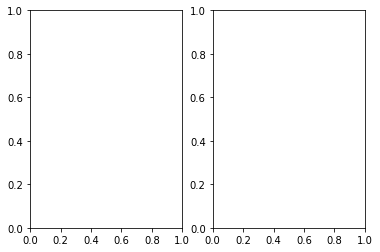

In [25]:
f,(ax1, ax2) = plt.subplots(1,2)

ax1.hist(logAge, bins=40, density=True)
ax1.set_xlabel('log(Age [yr?])')
ax1.set_yscale('log')

ax2.hist(logMass, bins=40, density=True)
ax2.set_xlabel('log(Mass [Msun])')
ax2.set_yscale('log')

In [ ]:
df = pd.read_csv("OCcompiled_hasAgeMass.csv")

data = np.vstack((df['logAge'].values, df['logMass'].values))
KDE = gaussian_kde(data)
sample = KDE.resample(size=int(1e5))

nbins = 40

f,(ax1, ax2) = plt.subplots(1,2)
ax1.hist(df['logAge'].values, bins=nbins, density=True)
ax1.hist(sample[0,:], bins=nbins, density=True, histtype='step')
ax1.set_xlabel('log(Age [yr?])')
ax1.set_yscale('log')

ax2.hist(df['logMass'].values, bins=nbins, density=True)
ax2.hist(sample[1,:], bins=nbins, density=True, histtype='step')
ax2.set_xlabel('log(Mass [Msun])')
ax2.set_yscale('log')

lt = 5
lm = 2
values = np.vstack([lt, lm])
print(KDE(values))
#NOTE: the age KDE seems to be missing the edges.  Maybe I should set those to zero automatically?